In [183]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

In [184]:
eldist = 0.023
eldia = 0.0075
size2 = 0.1
plc = mt.createWorld(start=[-size2, -size2, -size2], end=[size2+3*eldist, size2, 0], area=1e-6)
for i in range(4):
    pad = mt.createFacet(mt.createCircle(pos=[i*eldist, 0, 0], radius=eldia/2, nSegments=16, isHole=True)) 
    plc.copyBoundary(pad.boundary(0))
    plc.createBoundary(plc.nodes([plc.createNode(n.pos()).id() for n in pad.nodes() ]), marker=-10000-i) # -10000-1)
    plc.createNode([i*eldist, 0, -0.0003])

mesh = mt.createMesh(plc, quality=1.2)
print(mesh)
mesh.node(0).setMarker(-999)
mesh.node(1).setMarker(-1000)
print(np.unique(mesh.boundaryMarkers()))
pg.show(mesh, showMesh=True, markers=True, backend="trame")

25/10/23 - 18:58:21 - pyGIMLi - WARNING - Given data fits neither cell count nor node count:
25/10/23 - 18:58:21 - pyGIMLi - WARNING - 28515 vs. 0 vs. 1331


Mesh: Nodes: 2909 Cells: 13593 Boundaries: 28515
[-10003 -10002 -10001 -10000     -2     -1      0]


Widget(value="<iframe src='http://localhost:59121/index.html?ui=P_0x218f0b142b0_60&reconnect=auto' style='widt…

(<pyvista.plotting.plotting.Plotter at 0x218f0b142b0>, None)

In [185]:
shm = pg.DataContainerERT()
for i in range(4):
    shm.createSensor([i*eldist, 0, 0])

shm.addFourPointData(0, 3, 1, 2)
print(shm)
shm["k"] = 1.

Data: Sensors: 4 data: 1, nonzero entries: ['a', 'b', 'm', 'n', 'valid']


In [186]:
data = ert.simulate(mesh, shm, res=1.0, sr=False, verbose=True)#, calcOnly=True, returnFields=True)  # res=[[1, 1.0]]
data["k"] = 1. / data["rhoa"]

In [187]:
fop = ert.ERTModelling(sr=False, verbose=True)
fop.setData(shm)
fop.setMesh(mesh)
fop._core.setContactImpedances(np.ones(shm.sensorCount())*1e-12)
model = np.ones(mesh.cellCount()) * 100
res = fop.response(model)
print(res)
fop.createJacobian(model)
sens = fop.jacobian()[0]

25/10/23 - 18:58:24 - pyGIMLi - INFO - Found 1 regions.
25/10/23 - 18:58:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
25/10/23 - 18:58:25 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
25/10/23 - 18:58:26 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 20739 Cells: 108744 Boundaries: 114060


1 [703.8517578867]


In [188]:
mesh["sens"] = sens / mesh.cellSizes()
sli = mt.extract2dSlice(mesh)

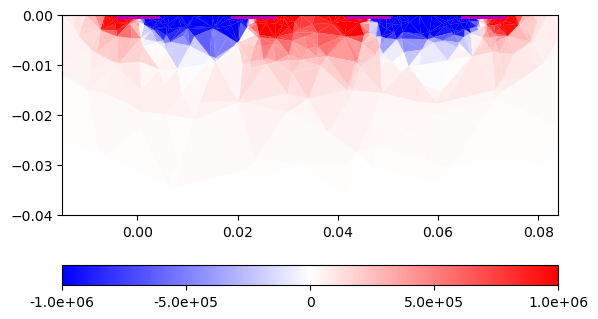

In [189]:
mm = 1e6
ax, cb = pg.show(sli, "sens", cMin=-mm, cMax=mm, cMap="bwr")
ax.set_xlim(-0.015, 3*eldist+0.015)
ax.set_ylim(-0.04, 0)
for i in range(4):
    ax.plot([i*eldist-eldia/2, i*eldist+eldia/2], [0, 0], "m-", lw=5)